In [0]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import AveragePooling2D, MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.models import Model, Sequential
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [0]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from scipy.optimize import fmin_l_bfgs_b

In [0]:
def VGG16_AvgPool(shape):
  # we want to account for features across the entire image
  # so get rid of the maxpool which throws away information
  vgg = VGG16(input_shape=shape, weights='imagenet', include_top=False)

  new_model = Sequential()
  for layer in vgg.layers:
    if layer.__class__ == MaxPooling2D:
      # replace it with average pooling
      new_model.add(AveragePooling2D())
    else:
      new_model.add(layer)

  return new_model

In [0]:
def VGG16_AvgPool_CutOff(shape, num_convs):
  # there are 13 convolutions in total
  # we can pick any of them as the "output"
  # of our content model

  if num_convs < 1 or num_convs > 13:
    print("num_convs must be in the range [1, 13]")
    return None

  model = VGG16_AvgPool(shape)
  new_model = Sequential()
  n = 0
  for layer in model.layers:
    if layer.__class__ == Conv2D:
      n += 1
    new_model.add(layer)
    if n >= num_convs:
      break

  return new_model

In [0]:
#As discussed in the lecture VGG subtracts the mean value of each color channel which is done by the preprocess_inputs function. 
#Therefore the unpreprocess function simply does the opposite operation.

def unpreprocess(img):
  img[..., 0] += 103.939
  img[..., 1] += 116.779
  img[..., 2] += 126.68
  img = img[..., ::-1]
  return img

In [0]:
def scale_img(x):
  x = x - x.min()
  x = x / x.max()
  return x

Mounted at /content/gdrive


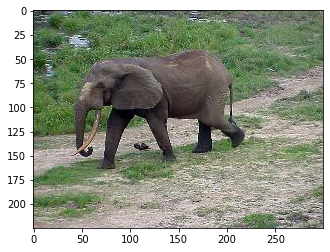

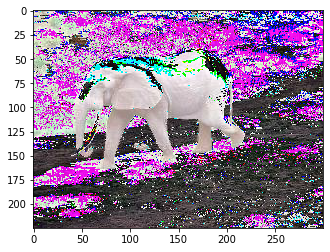

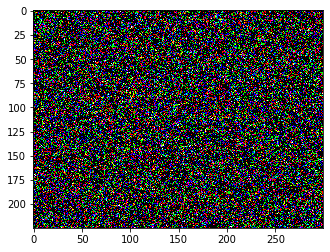

iter=0, loss=662.1428833007812
iter=1, loss=250.90415954589844
iter=2, loss=136.84713745117188
iter=3, loss=97.04901885986328
iter=4, loss=73.4713363647461
iter=5, loss=58.644290924072266
iter=6, loss=49.69339370727539
iter=7, loss=43.76581573486328
iter=8, loss=38.786216735839844
iter=9, loss=34.838619232177734


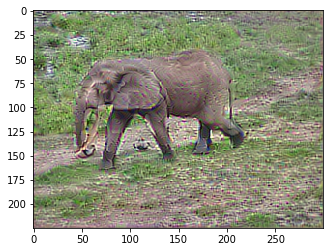

In [171]:
if __name__ == '__main__':
  
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  
  path = '/content/gdrive/My Drive/Colab Notebooks/Deep Learning: Advanced Computer Vision/image_0002.jpg'
  img = image.load_img(path)
  plt.imshow(img)
  plt.show()
  
  # convert image to array and preprocess for vgg
  x = image.img_to_array(img)      # (225, 300, 3)
  x = np.expand_dims(x, 0)         # or np.expand_dims(x, axis=0). Output = (1, 225, 300, 3)
  x = preprocess_input(x)          # (1, 225, 300, 3)
  
  plt.imshow(x[0].astype('uint8'))
  plt.show()
  
  # we'll use this throughout the rest of the script
  batch_shape = x.shape            # (1, 225, 300, 3)
  shape = x.shape[1:]              # (225, 300, 3)

  # make a content model
  # try different cutoffs to see the images that result
  content_model = VGG16_AvgPool_CutOff(shape, 9)

  # make the target
  target = K.variable(content_model.predict(x))
  # print(target.shape)        (1, 28, 37, 512)
  # print(content_model.output)             Tensor("block4_conv2_56/Relu:0", shape=(?, 28, 37, 512), dtype=float32)
  # print(content_model.output.shape)      (?, 28, 37, 512)
  # print(content_model.input.shape)       (?, 225, 300, 3)

  # try to match the image
  # define our loss in keras
  loss = K.mean(K.square(target - content_model.output))

  # gradients which are needed by the optimizer
  grads = K.gradients(loss, content_model.input)
  
  # 1) provide blank image as new content_model.input
  # 2) use content_model.input to determine new content_model.output
  # 3) use content_model.output to determine loss
  # 4) use loss to determine grads
  # 5) return loss & grads to update the blank image
  # 6) repeat from 1) onwards

  # just like theano.function
  get_loss_and_grads = K.function(
    inputs=[content_model.input],
    outputs=[loss] + grads
  )

  def get_loss_and_grads_wrapper(x_vec):
    # scipy's minimizer allows us to pass back
    # function value f(x) and its gradient f'(x)
    # simultaneously, rather than using the fprime arg
    #
    # we cannot use get_loss_and_grads() directly
    # input to minimizer func must be a 1-D array
    # input to get_loss_and_grads must be [batch_of_images]
    #
    # gradient must also be a 1-D array
    # and both loss and gradient must be np.float64
    # will get an error otherwise

    l, g = get_loss_and_grads([x_vec.reshape(*batch_shape)])         # print(g.shape) = (1, 225, 300, 3)
    return l.astype(np.float64), g.flatten().astype(np.float64)
  
  x = np.random.randn(np.prod(batch_shape))
  plt.imshow(x.reshape(*shape).astype('uint8'))      # .astype('uint8') added to remove the error 'Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)'
  #plt.imshow(x.reshape(*shape))
  plt.show()
  
  for i in range(10):
    x, l, _ = fmin_l_bfgs_b(func=get_loss_and_grads_wrapper, x0=x, maxfun=20)    # func should be a function that returns the value we're trying to minimize => loss
                                                                                 # x0 is the initial value of x
                                                                                 # x : array_like: Estimated position of the minimum.
                                                                                 # f : float: Value of func at the minimum.
    x = np.clip(x, -127, 127)
    # print("min:", x.min(), "max:", x.max())
    print("iter=%s, loss=%s" % (i, l))

  newimg = x.reshape(*batch_shape)               # (1, 225, 300, 3)
  final_img = unpreprocess(newimg)               # (1, 225, 300, 3)
  # print(final_img[0].shape)                    # (225, 300, 3)
  
  plt.imshow(scale_img(final_img[0]))
  plt.show()